In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from tqdm import tqdm 
from ultralytics import RTDETR
from multiprocessing import Pool

In [3]:
fundamental_matrices = {
    "A" : {
        "B": np.load("fundamental_matrices/AB.npy"),
        "C": np.load("fundamental_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("fundamental_matrices/BA.npy"),
        "C": np.load("fundamental_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("fundamental_matrices/CB.npy"),
        "A": np.load("fundamental_matrices/CA.npy"),
    }
}

In [4]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [5]:
#model = YOLO("yolov9e.pt")
#model.track("train/task1/02_query.mp4", show=True, tracker="./trackers/bytetrack.yaml", conf=0.1, iou=0.1, agnostic_nms=True, augment=True, max_det=1000) 

In [6]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

query = load_video("train/task1/02_query.mp4")
reference = load_video("train/task1/02_reference.mp4")

In [7]:
query.do_tracking()
reference.do_tracking()

In [8]:
camera_query = query.get_camera()
camera_reference = reference.get_camera()

print("Query camera:", camera_query)
print("Reference camera:", camera_reference)

Query camera: C
Reference camera: A


In [9]:
F = fundamental_matrices[camera_query][camera_reference] 
print(F)
F_inv = fundamental_matrices[camera_reference][camera_query] 
print(F_inv)

[[-5.7527e-07 -9.7317e-06    0.003172]
 [ 5.5402e-06  7.1693e-06   0.0029729]
 [ -0.0003995  -0.0036525           1]]
[[-5.7527e-07  5.5402e-06  -0.0003995]
 [-9.7317e-06  7.1693e-06  -0.0036525]
 [   0.003172   0.0029729           1]]


In [10]:
H = homography_matrices[camera_query][camera_reference]
print(H)
H_inv = homography_matrices[camera_reference][camera_query]
print(H_inv)

[[    0.82196     -1.7032      4155.6]
 [   -0.14479      2.8583     -238.45]
 [-0.00067971   0.0035915           1]]
[[     -4.734     -25.259       17296]
 [   -0.76251     -7.9624      3239.4]
 [ -0.0020016  -0.0028567           1]]


In [11]:
query_index = 1 
reference_index = 270 

In [12]:

# Removes those points that would be outside the frame when transformed to the other camera's frame.
def filter_points_homography(points, H):
    transformed_points = cv.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), H).squeeze()

    in_bounds = np.logical_and(
        np.logical_and(transformed_points[:, 0] >= 0, transformed_points[:, 0] < FRAME_WIDTH),
        np.logical_and(transformed_points[:, 1] >= 0, transformed_points[:, 1] < FRAME_HEIGHT)
    )

    return points[in_bounds]


In [13]:
def similarity_epipolar(query, reference, visualize=False):
    moving_pixels_query = query.moving_pixels()
    moving_pixels_reference = reference.moving_pixels()

    # Get the actual coordinates of the moving pixels
    rows, cols = np.where(moving_pixels_query)
    points_query = np.stack((cols, rows), axis=1) 

    rows, cols = np.where(moving_pixels_reference)
    points_reference = np.stack((cols, rows), axis=1) 

    if len(points_query) == 0 or len(points_reference) == 0:
        return None

    # Filter points that would be outside the frame when transformed to the other camera's frame.
    points_query = filter_points_homography(points_query, H)
    points_reference = filter_points_homography(points_reference, H_inv)

    if len(points_query) == 0 or len(points_reference) == 0:
        return None

    # Downsample points to avoid too many points
    if len(points_query) > 6000:
        indices = np.random.choice(len(points_query), 6000, replace=False)
        points_query = points_query[indices]

    if len(points_reference) > 6000:
        indices = np.random.choice(len(points_reference), 6000, replace=False)
        points_reference = points_reference[indices]

    # Compute the epipolar lines for the query points in the reference frame.
    lines = cv.computeCorrespondEpilines(points_query.reshape(-1, 1, 2), 1, F).squeeze()
    score = 0

    # Just prepare the plots if visualization is enabled.
    if visualize:
        query_plot = query.raw().copy()
        reference_plot = reference.raw().copy()

    chosen = np.zeros(len(points_reference), dtype=bool)
    for i, line in enumerate(lines):
        distances = distance_point_to_line(points_reference, line)
        distances[chosen] = np.inf  # Ignore already chosen points

        minimum_index = np.argmin(distances)
        minimum_distance = distances[minimum_index]

        if minimum_distance < 5:
            score+=1

            # Mark this point as chosen so we don't use it again.
            chosen[minimum_index] = True

            if visualize:
                color = np.random.randint(0, 255, size=3).tolist()
                cv.circle(query_plot, (points_query[i][0], points_query[i][1]), 10, color, -1)
                close_point = points_reference[minimum_index]
                cv.circle(reference_plot, (close_point[0], close_point[1]), 10, color, -1)
                draw_epiline(line, reference_plot, color=color) 
    
    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(20, 30))
        axs[0].imshow(moving_pixels_query)
        axs[1].imshow(moving_pixels_reference)
        plt.show()
        
        fig, axs = plt.subplots(1, 2, figsize=(20, 30))
        axs[0].imshow(query_plot)
        axs[0].set_title("Query Frame")
        axs[0].axis('off')
        axs[1].imshow(reference_plot)
        axs[1].set_title("Reference Frame")
        axs[1].axis('off')
        plt.show()

    return score

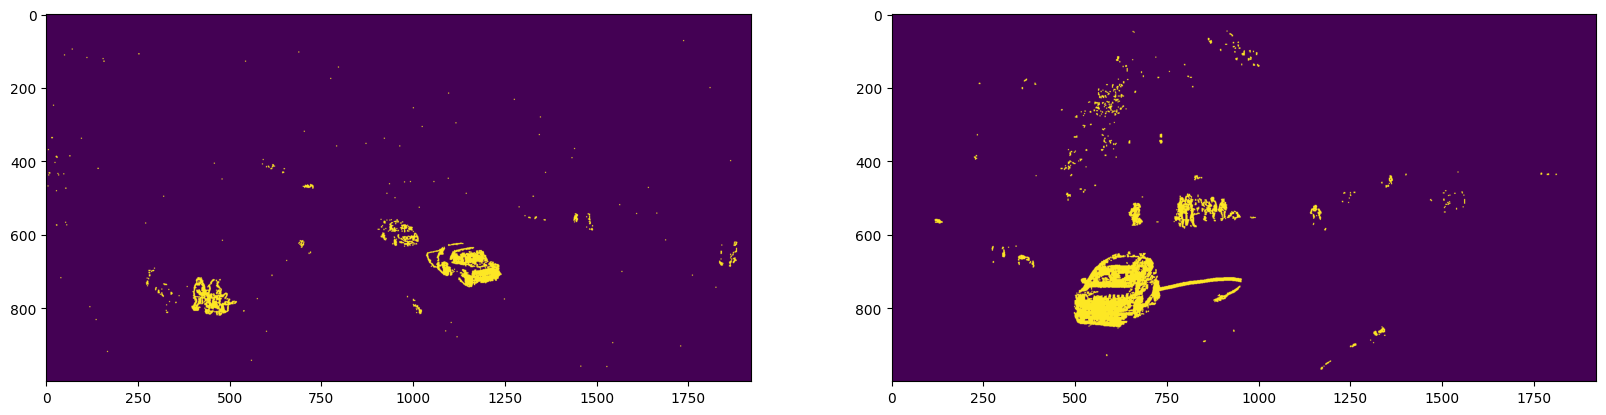

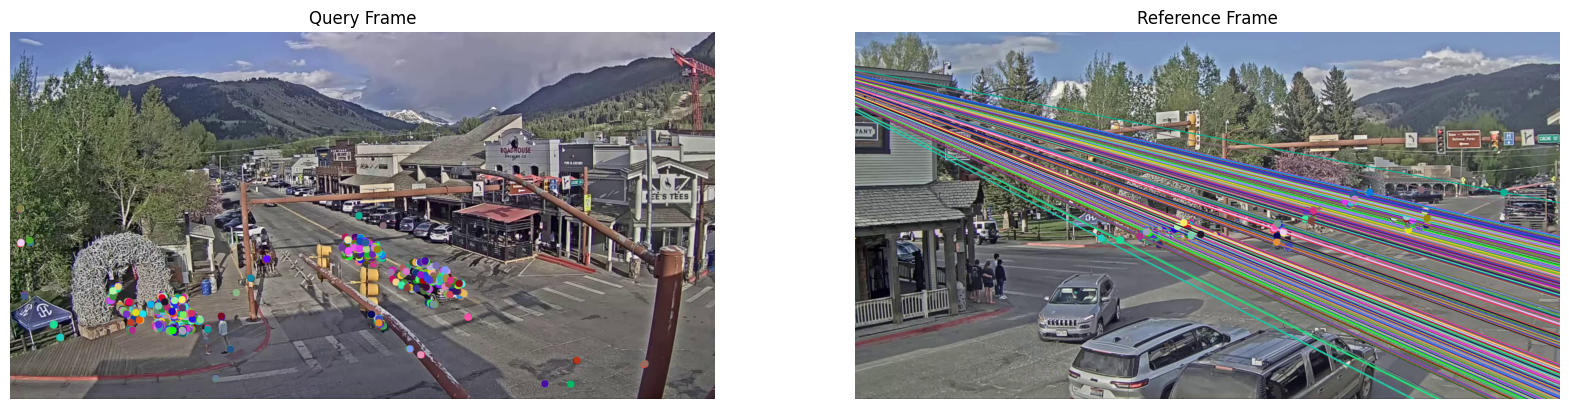

2278


In [14]:
similarity_score = similarity_epipolar(query.get_frame(query_index), reference.get_frame(reference_index), 
                              visualize=True)
print(similarity_score)

In [15]:
def overlap_score(reference_start_index):
    num_query_frames = query.num_frames()
    score = 0
    for t in range(0, num_query_frames, 10):
        query_frame = query.get_frame(t)
        reference_frame = reference.get_frame(reference_start_index + t)

        cost = similarity_epipolar(query_frame, reference_frame)
        if cost is not None:
            score += cost

    return (reference_start_index, score)

In [16]:
num_query_frames = query.num_frames()
num_reference_frames = reference.num_frames()
print(num_query_frames)
costs = []

with Pool() as pool:
    starts = range(0, num_reference_frames-num_query_frames+1, 10)
    results = list(tqdm(pool.imap(overlap_score, starts), total=len(starts)))

180


100%|██████████| 162/162 [00:58<00:00,  2.79it/s]


[(0, 34608), (10, 36719), (20, 38674), (30, 40502), (40, 42350), (50, 44105), (60, 45200), (70, 46716), (80, 46937), (90, 46319), (100, 45890), (110, 45911), (120, 45887), (130, 45987), (140, 46260), (150, 45923), (160, 45913), (170, 45555), (180, 45207), (190, 44742), (200, 43156), (210, 41610), (220, 40135), (230, 38661), (240, 36340), (250, 35416), (260, 34904), (270, 34161), (280, 33250), (290, 32127), (300, 31136), (310, 29789), (320, 28205), (330, 27223), (340, 25682), (350, 24605), (360, 24228), (370, 24664), (380, 25879), (390, 27918), (400, 29444), (410, 31976), (420, 33545), (430, 35283), (440, 36316), (450, 37026), (460, 37785), (470, 39066), (480, 40955), (490, 42592), (500, 43779), (510, 44824), (520, 45107), (530, 45881), (540, 46720), (550, 47751), (560, 50194), (570, 52273), (580, 54483), (590, 56309), (600, 57824), (610, 59319), (620, 60812), (630, 62314), (640, 63615), (650, 65598), (660, 66442), (670, 68187), (680, 69298), (690, 71028), (700, 72545), (710, 73611), (7

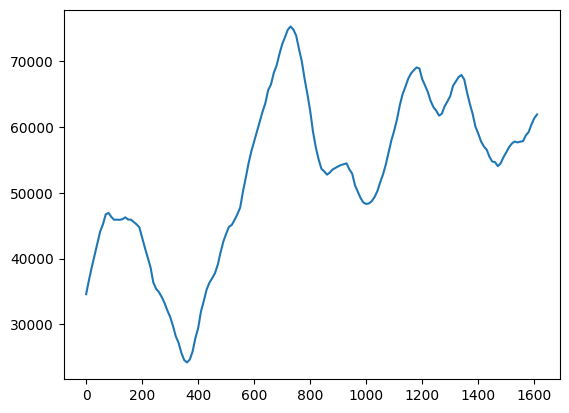

In [17]:
print(results)
plt.plot([result[0] for result in results], [result[1] for result in results])

argmax = np.argmax([result[1] for result in results])
print(results[argmax])